In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.features.importances import FeatureImportances
import plotly_express as px
import pickle
import os

### labelled large dataset (only subset)

In [59]:
df_l = pd.read_csv('../Data Files/scaledValidation - Sheet1.csv')
df_l.drop('Unnamed: 4', axis=1, inplace=True)
df_l = df_l[['VideoId', 'Manual Label']]
df_l['VideoId'] = df_l['VideoId'].str[32:]
df_l = df_l[df_l['Manual Label'].isin(['b','f'])]
print(df_l.shape)
df_l.head()

(68, 2)


,VideoId,Manual Label
0,cVhcbgxv3yE,f
1,iMtXqTmfta0,b
3,bSWEbaoxa7c,b
4,fch2yJ11pNg,b
5,WjD7jLmS3ro,b


### merge and clean large (unlabelled) data

In [60]:
df = pd.read_json('../../../data/uniqueScaledDataset.json')
print(df.shape)
df.head()

(38459, 14)


,viewCount,description,tags,predClass,channelId,videoId,comments,categoryId,commentCount,channelTitle,redirectedDomains,domains,title,completeDomains
0,298744,After months of searching for a constant onlin...,"[Money (TV Episode), How-to (Media Genre), Bus...",f,UCFqanUMpCMh54RmqRFh8hZw,dFotOUq0Z4E,"[over $34,000 was added to my paypal and that ...",22,240,ProfitClicksDelux,"[http://www.neobux.com/?r=dirven, https://imgu...","[neobux, imgur]",How to make money online just by clicking ads ...,"[http://www.neobux.com/?r=dirven, http://imgur..."
1,44244,hii.\nfriends.\n[[[[[[[[[[[[[[[[[[[[[[[[[[[[th...,"[earn money, how to, ads, paer, click, $5, per...",f,UC775w8nPdhDCVJ4IkCczVPw,xO5B6JcR5TQ,"[Earn Money\r\nhttps://youtu.be/NsqaXAMhl3k, n...",22,56,Trick Technology,[],[],earn money $2.to$5. ads click per day. in hindi.,[]
2,1066128,Create Free Bitcoin Wallet:- zebpay:- http://l...,[work from home],f,UCdWrX9xcYhCW4RwwYT22bpg,adh4xyzygBw,"[Sir ye site nhi chal rhi bhad ho gyi h kya, M...",26,2105,helpfromankit,"[http://link.zebpay.com/ref/REFANKI3843, http:...","[link.zebpay, myadvertisingpays]",view Only 10 Ads Per Day and Earn Money Every ...,"[http://link.zebpay.com/ref/REFANKI3843, http:..."
3,7567,My #1 Recommendation To Earning Income Online ...,"[make money online, tyler pratt, tylerpratt, e...",f,UCRfWuSls0R7jQazuddXiPvQ,H1KmFXp2Ymg,"[Didn't work, The real big money?? LOL cl...",26,9,Tyler Pratt,"[https://go.tylerpratt.com/, https://go.tylerp...","[go.tylerpratt, go.tylerpratt, facebook, insta...",Easy Side Online Job Clicking Ads and Making M...,"[http://go.tylerpratt.com/, http://go.tylerpra..."
4,9107,"Please watch: ""how to earn money from internet...","[Earn money By Click Ads, make money online, m...",f,UCupgYB_GTCWX6BLh-Ui_VFg,-YtKEcbVsKE,"[madarchod Frank hi, If you have website and e...",28,19,Tech 4 Digital,"[https://www.youtube.com/watch?v=DBZOdbHELXU, ...","[youtube, youtube, youtube, youtube, youtube, ...",Make money by Click ads क्लिक करके पैसे कमाओ ...,"[https://www.youtube.com/watch?v=DBZOdbHELXU, ..."


In [61]:
df_l = pd.merge(df, df_l, how='inner', left_on='videoId', right_on='VideoId')
print(df_l.shape)
df_l.head()

(68, 16)


,viewCount,description,tags,predClass,channelId,videoId,comments,categoryId,commentCount,channelTitle,redirectedDomains,domains,title,completeDomains,VideoId,Manual Label
0,50638,Earn $500 per sign up in the Los Angeles Area....,"[uber, lyft, rideshare, sign up, bonus, how to...",f,UCPmFGlgNyvdSwDIKVfv5qwg,z8-N86KHCEs,[Doesnt the link in the description make you m...,22,3,RideshareInvestor,[https://www.uber.com/a/join?exp_hvp=1&invite_...,[uber],Make money online with ppc ads. Sign up for Ub...,[https://partners.uber.com/i/8m87zcbpue],z8-N86KHCEs,f
1,38336,http://joinankur.com : join my team here to ge...,"[mass email magician, email list magician, col...",b,UCTiribC11Co_ft-r9wrunew,6tKK00krGoI,"[How does it work, Guys I swear I just got fre...",24,59,Ankur Agarwal,[http://joinankur.com/],[joinankur],"Collect Emails , Send Emails And Make Money On...",[http://joinankur.com],6tKK00krGoI,b
2,180,In it we learn how to implement Banner Ads in ...,"[how to add google adsense to android app, how...",f,UCV7hdDVonvC2ZOWNcHmM6eg,2ij6cSpEw2o,[Mobile number dena na muchhe kuchh puchh na hai],22,3,Easy Tut 4 U,[],[],Admob Banner ADS Tutorial Hindi by Easy Tut 4 U,[],2ij6cSpEw2o,f
3,14099,,"[Clicker Heroes, money glitch, clicker heroes ...",b,UC5QiV14A4UVAu8zwcO6L0VA,sSdiQ95l1rQ,"[I got 34,735#. Level 434, I when from 10k ...",20,9,NaCl Daddy,[],[],Clicker Heroes Easy MONEY GLITCH,[],sSdiQ95l1rQ,b
4,481,5 Easiest Ways To Make Money Online Internet I...,"[ways to make money online, india, hindi, onli...",f,UCniia-3AGf-HzVXooVcp1lw,AZyltjsXWBc,[],1,0,study tips,[https://www.youtube.com/watch?v=1yYpRSYkwIc&f...,"[youtube, youtube, youtube, youtube, youtube, ...",Top 5 Best Easy Ways To Earn Money Online Indi...,"[https://youtu.be/1yYpRSYkwIc, https://youtu.b...",AZyltjsXWBc,b


In [62]:
df_l['videoId'].is_unique

True

In [63]:
len(df_l['channelId'].unique())

68

In [64]:
df_l.dtypes

viewCount            object
description          object
tags                 object
predClass            object
channelId            object
videoId              object
comments             object
categoryId           object
commentCount         object
channelTitle         object
redirectedDomains    object
domains              object
title                object
completeDomains      object
VideoId              object
Manual Label         object
dtype: object

In [65]:
# df_l['classification'] = df_l['classification'].astype('category')
df_l['commentCount'][df_l['commentCount'] == 'No commentCount'] = np.NaN
df_l['commentCount'] = df_l['commentCount'].astype('float')
# df_l['category'] = df_l['category'].astype('category')
df_l['viewCount'][df_l['viewCount'] == 'No viewCount'] = np.NaN
df_l['viewCount'] = df_l['viewCount'].astype('float')
# df_l['linksCount'] = df_l['linksCount'].astype('float')
df_l['Manual Label'] = df_l['Manual Label'].astype('category')

C:\Users\ruote\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [66]:
df_l = df_l[['categoryId', 'channelId', 'channelTitle', 'Manual Label',
       'commentCount', 'comments', 'completeDomains',
       'description', 'domains',
       'redirectedDomains', 'tags', 'title',
       'videoId', 'viewCount']]

In [116]:
df_cat = pd.read_json('../../Data Collection/Data Files/dataset.json')
df_cat = df_cat[['category', 'categoryId']]
df_cat.drop_duplicates(inplace=True)
df_cat.set_index('categoryId', inplace=True)
print(df_cat.shape)
df_cat.head()

(16, 1)


,category
categoryId,
22,People & Blogs
2,Autos & Vehicles
26,How-to & Style
27,Education
28,Science & Technology


In [130]:
df_l['category'] = df_l['categoryId'].apply(lambda c_id: df_cat.loc[int(c_id)][0])

In [132]:
df_l.drop('categoryId', axis=1, inplace=True)
df_l['category'] = df_l['category'].astype('category')

In [134]:
df_l.to_pickle('../Data Files/labelled_large.pkl')

### preprocessing

In [136]:
df_l = pd.read_pickle('../Data Files/labelled_large.pkl')

In [137]:
with open(f'results/RF_grid_5Kfold_results.pkl', 'rb') as f:
    cv_clf = pickle.load(f)
with open(f'results/RF_grid_5Kfold_encoder.pkl', 'rb') as f:
    enc = pickle.load(f)

In [138]:
data = df_l[['Manual Label','description','title','tags']]

data['feature'] = (data['description'] + ' ' 
                   + data['title'] + ' ' 
                   + data['tags'].apply(lambda l: ' '.join(l)))
data.drop(['description','title','tags'], 
          axis=1, inplace=True)

data['feature'] = (data['feature']
                   .str.encode('ascii', 'ignore')
                   .str.decode('utf-8')
                   .astype(str))
data.head()

C:\Users\ruote\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\ruote\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\ruote\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[

,Manual Label,feature
0,f,Earn $500 per sign up in the Los Angeles Area....
1,b,http://joinankur.com : join my team here to ge...
2,f,In it we learn how to implement Banner Ads in ...
3,b,Clicker Heroes Easy MONEY GLITCH Clicker Her...
4,b,5 Easiest Ways To Make Money Online Internet I...


In [139]:
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
en_stop = get_stop_words('en')

In [140]:
data['feature'] = (data['feature'].str
                   .lower()
                   .replace(r'\d+', '', regex=True)
                   .apply(lambda s: tokenizer.tokenize(s))
                   .apply(lambda toks: [j for j in toks if not j in en_stop])
                   .apply(lambda toks: [p_stemmer.stem(j) for j in toks])
                   .apply(lambda toks: ' '.join(toks))
                   .replace(r'www|http|https|com', '', regex=True)
                  )

C:\Users\ruote\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [141]:
data_x = enc.transform(data['feature'])

### predictions

In [142]:
best_clf = cv_clf.best_estimator_

In [143]:
best_clf.score(data_x, data['Manual Label'].cat.codes)

0.7941176470588235

In [144]:
preds = best_clf.predict(data_x)

In [145]:
print(classification_report(data['Manual Label'].cat.codes, preds,
                            target_names=data['Manual Label'].cat.categories))

              precision    recall  f1-score   support

           b       0.92      0.76      0.83        45
           f       0.65      0.87      0.74        23

   micro avg       0.79      0.79      0.79        68
   macro avg       0.78      0.81      0.79        68
weighted avg       0.83      0.79      0.80        68



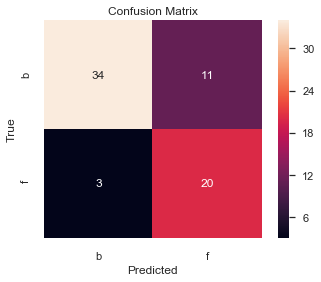

In [146]:
cmat = confusion_matrix(data['Manual Label'].cat.codes, preds)
ax = sns.heatmap(cmat, annot=True, square=True, 
                 xticklabels=data['Manual Label'].cat.categories,
                 yticklabels=data['Manual Label'].cat.categories);
ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='True');

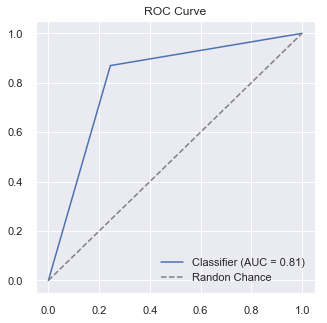

In [147]:
fpr, tpr, _ = roc_curve(data['Manual Label'].cat.codes, preds)
auc = roc_auc_score(data['Manual Label'].cat.codes, preds)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label=f'Classifier (AUC = {auc:.2f})')
ax.plot([0,1], [0,1], linestyle='dashed', color='grey', label='Randon Chance')
ax.set_title('ROC Curve')
ax.legend();

In [148]:
df_l['prediction'] = preds

### analysis

In [149]:
def transformer(row):
    if row['Manual Label'] == 'f': # positive
        if row['prediction'] == 1: # positive
            return 'TP'
        elif row['prediction'] == 0: # negative
            return 'FN'
    elif row['Manual Label'] == 'b': # negative
        if row['prediction'] == 1: # positive
            return 'FP'
        elif row['prediction'] == 0: # negative
            return 'TN'

df_l['results'] = df_l.apply(transformer, axis=1)
df_l.head()

,channelId,channelTitle,Manual Label,commentCount,comments,completeDomains,description,domains,redirectedDomains,tags,title,videoId,viewCount,prediction,results,category
0,UCPmFGlgNyvdSwDIKVfv5qwg,RideshareInvestor,f,3.0,[Doesnt the link in the description make you m...,[https://partners.uber.com/i/8m87zcbpue],Earn $500 per sign up in the Los Angeles Area....,[uber],[https://www.uber.com/a/join?exp_hvp=1&invite_...,"[uber, lyft, rideshare, sign up, bonus, how to...",Make money online with ppc ads. Sign up for Ub...,z8-N86KHCEs,50638.0,1,TP,People & Blogs
1,UCTiribC11Co_ft-r9wrunew,Ankur Agarwal,b,59.0,"[How does it work, Guys I swear I just got fre...",[http://joinankur.com],http://joinankur.com : join my team here to ge...,[joinankur],[http://joinankur.com/],"[mass email magician, email list magician, col...","Collect Emails , Send Emails And Make Money On...",6tKK00krGoI,38336.0,1,FP,Entertainment
2,UCV7hdDVonvC2ZOWNcHmM6eg,Easy Tut 4 U,f,3.0,[Mobile number dena na muchhe kuchh puchh na hai],[],In it we learn how to implement Banner Ads in ...,[],[],"[how to add google adsense to android app, how...",Admob Banner ADS Tutorial Hindi by Easy Tut 4 U,2ij6cSpEw2o,180.0,1,TP,People & Blogs
3,UC5QiV14A4UVAu8zwcO6L0VA,NaCl Daddy,b,9.0,"[I got 34,735#. Level 434, I when from 10k ...",[],,[],[],"[Clicker Heroes, money glitch, clicker heroes ...",Clicker Heroes Easy MONEY GLITCH,sSdiQ95l1rQ,14099.0,0,TN,Gaming
4,UCniia-3AGf-HzVXooVcp1lw,study tips,b,0.0,[],"[https://youtu.be/1yYpRSYkwIc, https://youtu.b...",5 Easiest Ways To Make Money Online Internet I...,"[youtube, youtube, youtube, youtube, youtube, ...",[https://www.youtube.com/watch?v=1yYpRSYkwIc&f...,"[ways to make money online, india, hindi, onli...",Top 5 Best Easy Ways To Earn Money Online Indi...,AZyltjsXWBc,481.0,1,FP,Film & Animation


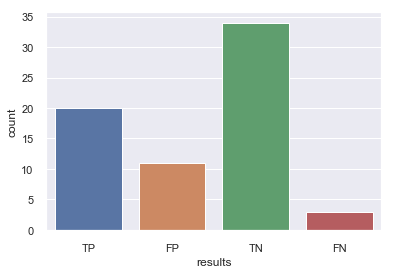

In [150]:
# just a sanity check (this should be same as the confusion matrix above)
sns.countplot(df_l['results']);

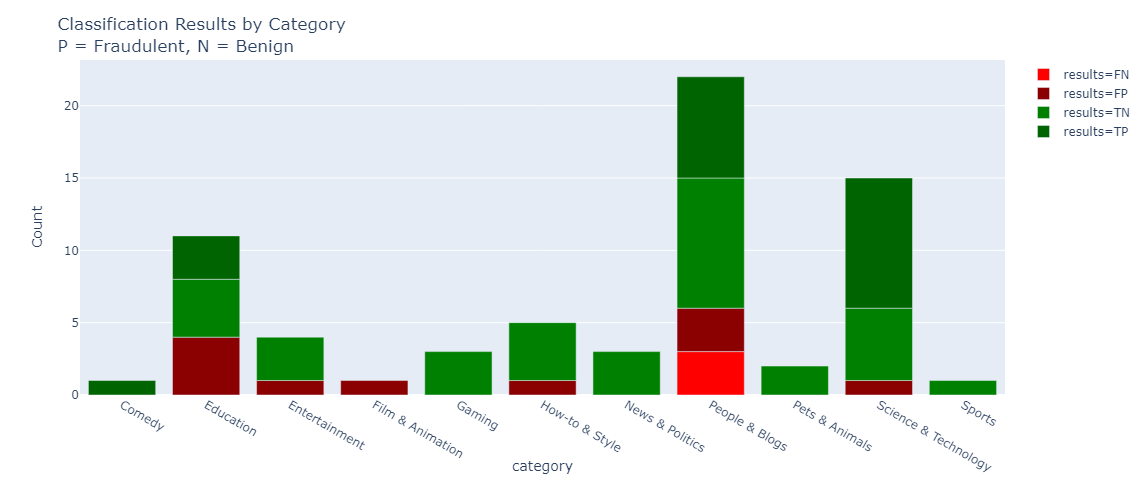

In [218]:
color_map = {
    'TP': 'darkgreen',
    'TN': 'green',
    'FP': 'darkred',
    'FN': 'red',
}
fig = px.bar(df_l.groupby(['category', 'results']).count()['channelId'].reset_index(), 
             x='category', y='channelId', color='results', color_discrete_map=color_map)
fig.layout.height = 500
fig.layout.width = 800
fig.layout.yaxis.title = 'Count'
fig.layout.title = 'Classification Results by Category<br>P = Fraudulent, N = Benign'

fig